In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1-D Linear Kalman Filter

### double integrater simulation

In [2]:
# model
dt = 0.1
m = 2
A = np.array([[1,dt],
              [0,1]])
B = np.array([[0],
              [1/m*dt]])
C = np.array([[1,0]])
ss = [A, B, C]

In [3]:
def ss_model(ss, x, u, e=None):
    A, B, C = ss
    if e is None:
        return A @ x + B * u
    else:
        return A @ x + B * u + e #e is process noise

In [4]:
def double_integrater_simulation(ss, u_arr, process_noise, sensor_noise, dt=0.1):
    n = len(u_arr)
    df_sim = pd.DataFrame()
    df_sim['u'] = u_arr
    df_sim['t'] = df_sim.index.to_numpy()*dt
    df_sim['x'] = np.zeros(n)
    df_sim['v'] = np.zeros(n)
    df_sim['process_noise'] = process_noise
    df_sim['sensor_noise'] = sensor_noise
    
    for i in range(len(df_sim)-1):
        state = df_sim.loc[i,['x','v']].to_numpy()[:,None]
        u = df_sim.loc[i+1,'u']
        e = df_sim.loc[i+1,'process_noise']
        state_curr = ss_model(ss, state, u, e)
        df_sim.loc[i+1,['x','v']] = state_curr[:,0]
    
    x_noise = np.random.normal(size=n)*0.5
    df_sim['x_meas'] = df_sim.x + df_sim.sensor_noise
    return df_sim

In [5]:
np.random.seed(1)
u = np.hstack([np.ones(50), -np.ones(50)])
n = len(u)
sensor_noise = np.random.normal(size=n)*0.5
process_noise = np.random.normal(size=n)*0.05

df_sim = double_integrater_simulation(ss,u, process_noise, sensor_noise)

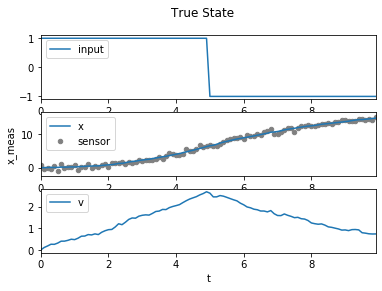

In [6]:
fig, axarr = plt.subplots(3,1)
df_sim.plot(x='t',y='u', ax=axarr[0], label='input')
df_sim.plot(x='t',y='x', ax=axarr[1])
df_sim.plot.scatter(x='t',y='x_meas', ax=axarr[1], color='grey', label='sensor')
df_sim.plot(x='t',y='v', ax=axarr[2])
for ax in axarr:
    ax.legend(loc='upper left')
plt.suptitle('True State');

### Compare : Dead Reckoning (No position sensor feedback) 

In [7]:
df_sim['x_dr'] = 0
df_sim['v_dr'] = 0
for i in df_sim.index[:-1]:
    state_prev = df_sim.loc[i,['x_dr','v_dr']].to_numpy()[:,None]
    u = df_sim.loc[i+1,'u']
    state_curr = A @ state_prev + B * u
    df_sim.loc[i+1,['x_dr','v_dr']] = state_curr[:,0]


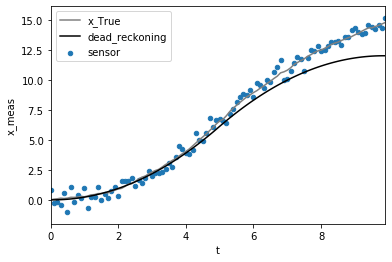

In [8]:
fig, ax = plt.subplots()

df_sim.plot(x='t',y='x',color='gray',ax=ax, label='x_True')
df_sim.plot(x='t',y='x_dr', color='k', ax=ax, label='dead_reckoning')
df_sim.plot.scatter(x='t',y='x_meas', ax=ax, label='sensor')


### State Estimation using Kalman Filter

In [9]:
df_sim['x_kf'] = 0
df_sim['v_kf'] = 0

In [10]:
Q = np.eye(2)
R = 50

In [11]:
P = np.zeros([2,2])
state_model_only = np.array([[0,0]]).T
for i in df_sim.index[:-1]:    
    state_prev = df_sim.loc[i,['x_kf','v_kf']].to_numpy()[:,None]
    u = df_sim.loc[i+1,'u']
    P = A@P@A.T+Q
    y = df_sim.loc[i+1,'x_meas']
    
    #state prediction
    state_curr_priori = A@state_prev + B * u
    #update
    K = P@C.T@np.linalg.pinv(C@P@C.T + R)
    state_curr_posteriori = state_curr_priori + K@(y-C@state_curr_priori)
    P = P-K@C@P

    df_sim.loc[i+1,['x_kf','v_kf']] = state_curr_posteriori[:,0]


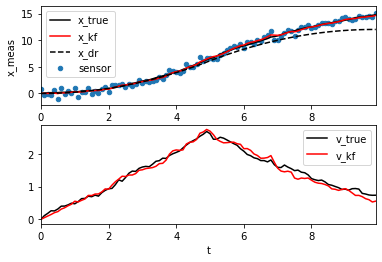

In [12]:
fig, axarr = plt.subplots(2,1)

df_sim.plot(x='t',y='x',color='k', label='x_true',ax=axarr[0])
df_sim.plot(x='t',y='x_kf',color='r',ax=axarr[0])
df_sim.plot(x='t',y='x_dr',linestyle='--',color='k',ax=axarr[0])
df_sim.plot.scatter(x='t',y='x_meas', label='sensor', ax=axarr[0])


df_sim.plot(x='t',y='v',color='k',label='v_true',ax=axarr[1])
df_sim.plot(x='t',y='v_kf',color='r',ax=axarr[1])

### Visualization

In [13]:
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
def draw_car(pos, ax, **kwargs):
    x, y = pos
    w, h = 1, 0.5
    rect = Rectangle((-w/2+x,-h/2+y), 1, 0.5, fc='none', **kwargs)
    ax.add_patch(rect)
    return rect

In [14]:
import sys 
sys.path.append('..')

In [15]:
from animake import AniMaker

In [16]:
def make_legend_arrow(legend, orig_handle,
                      xdescent, ydescent,
                      width, height, fontsize):
    p = mpatches.FancyArrow(0, 0.5*height, width, 0, length_includes_head=True, head_width=0.75*height )
    return p

In [17]:
def ani_init():
    fig, axarr = plt.subplots(3,1, figsize=[6,6])
    handler_map={mpatches.FancyArrow : HandlerPatch(patch_func=make_legend_arrow)}
    
    pos = [0,0]
    #
    car1 = draw_car(pos, axarr[0], label='car', ec='k')
    v1 = axarr[0].arrow(0,0, 0.1, 0, label='velocity', 
                        head_width=0.3, head_length=0.3, fc='k', ec='k')
    
    #
    car_dr = draw_car(pos, axarr[1], linestyle='dashed', label='car', ec='b', linewidth=2)
    car_true2 = draw_car(pos, axarr[1], label='car', ec='grey')
    v2 = axarr[1].arrow(0,0, 0.1, 0, label='velocity', 
                        head_width=0.3, head_length=0.3, fc='b', ec='b', linestyle='--')
    sens = axarr[2].scatter(0, 0, color='r', alpha=0.6, label='sensor')
    
    #
    car_kf = draw_car(pos, axarr[2], linestyle='dashed', label='car', ec='r', linewidth=2)
    car_true3 = draw_car(pos, axarr[2], label='car', ec='grey')
    v3 = axarr[2].arrow(0,0, 0.1, 0, label='velocity', 
                        head_width=0.3, head_length=0.3, fc='r', ec='r', linestyle='--')
    
    elements1 = [car1, v1]
    elements2 = [car_dr, v2]
    elements3 = [car_kf, v3, sens]
    cars = [car1, car_dr, car_true2, car_kf, car_true3]
    temp_elements = [v1, v2, v3]
    elements = [elements1, elements2, elements3]
    titles = ['True State','No Position sensor Feedback (Dead Reckoning)','State Estimate (KF)']
    for element, ax, title in zip(elements, axarr, titles):
        ax.set_xlim([-1,20])
        ax.set_ylim([-2,2])
        ax.set_title(title)
        ax.legend(handles=element, loc='upper left',handler_map=handler_map)
        ax.grid()
    plt.tight_layout()
    return axarr, cars, temp_elements

In [18]:
def remove_elements(elements):
    for element in elements:
        for patch in element:
            patch.remove()

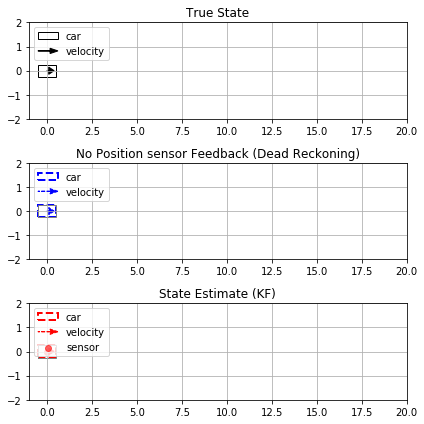

In [19]:
ani_init();

In [20]:
anim = AniMaker()
axarr, cars, temp_elements = ani_init()
car1, car_dr, car_true2, car_kf, car_true3 = cars
anim.set_snapshot()

for i,row in df_sim.iterrows():
    
    for element in temp_elements:
        element.remove()
    #
    x_true = row.x
    v_true = row.v
    x_meas = row.x_meas
    x_dr = row.x_dr
    v_dr = row.v_dr
    x_kf = row.x_kf
    v_kf = row.v_kf
    
    
    meas2 = axarr[2].scatter(x_meas, 0, color='r', alpha=0.3)
    
    
    car1.set_x(x_true-0.5)
    v1 = axarr[0].arrow(x_true,0, v_true*2, 0, head_width=0.3, head_length=0.3, fc='k', ec='k')
    
    car_dr.set_x(x_dr-0.5)
    car_true2.set_x(x_true-0.5)
    v2 = axarr[1].arrow(x_dr,0, v_dr*2, 0, head_width=0.3, head_length=0.3, fc='b', ec='b',linestyle='--')
    
    car_kf.set_x(x_kf-0.5)
    car_true3.set_x(x_true-0.5)
    v3 = axarr[2].arrow(x_kf,0, v_kf*2, 0, 
                        head_width=0.3, head_length=0.3, fc='r', ec='r',
                        linestyle='--')
    
    anim.set_snapshot()
    temp_elements = [meas2, v1, v2, v3]
    
plt.close()


image added:  101


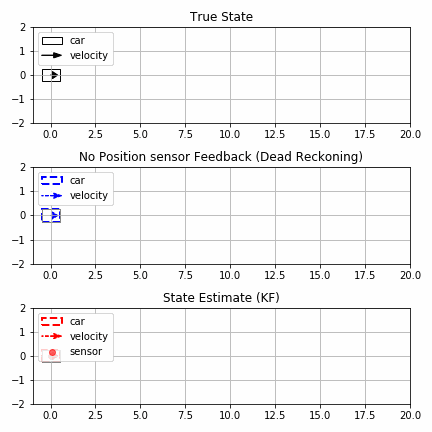

In [21]:
from IPython.display import Image
anim.make_gif('out_linear_KF.gif')
Image(filename="out_linear_KF.gif")